## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Загружаем исходные данные

In [2]:
train = np.loadtxt('data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('data/digit/test.csv', delimiter=',', skiprows=1)

In [19]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = train[:, 1:]
#test_img = np.resize(test, (test.shape[0], 28, 28))

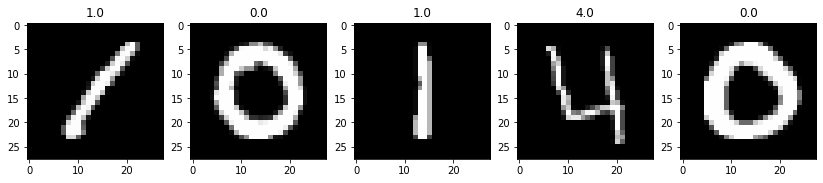

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

### Для решения этой задачи будем применять модель KNeighborsClassifier

Сперва применим KNeighborsClassifier на данных без обработки, чтобы получить первичный бенчмарк

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_img, train_label, test_size=0.2,random_state=42)



In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(x_train, y_train)

print(knn.score(x_val, y_val))

0.9632142857142857


Видим, что получили уже очень высокий score без предобработки данных. Попробуем найти дискриптор для данных и посмотрим как это повлияет на качество

In [24]:
# Текащая размерность данных
x_train.shape

(33600, 784)

### Применение HOGDescriptor и KNeighborsClassifier для классификации

#### Задаем параметры для вычисления дескриптора

In [30]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

In [36]:
# Вычисляем дескрипторы для изображений

train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

descriptors_train = np.empty([len(train_img), 144])
for i in range(len(train_img)):
    descriptors_train[i] = hog.compute(np.uint8(train_img[i]))
    
descriptors_test = np.empty([len(test_img), 144])
for i in range(len(test_img)):
    descriptors_test[i] = hog.compute(np.uint8(test_img[i]))

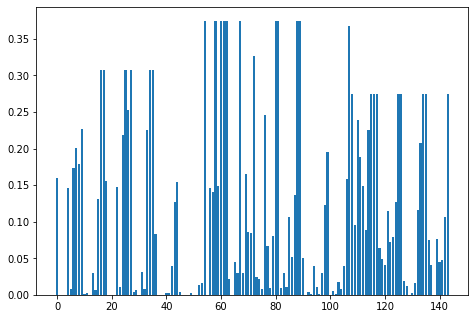

In [37]:
# дискриптор из тренировочной выборки под номером 4

from matplotlib import pyplot as plt

descriptor = descriptors_train[3]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(descriptor)), descriptor.reshape(-1))
plt.show()

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(descriptors_train, train_label, test_size=0.2,random_state=42)

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(x_train, y_train)

print(knn.score(x_val, y_val))


0.9692857142857143


In [42]:
# В изначальном виде тренировочные данные имели размерность (33600, 784), то есть качество модели осталось таким же высоким,
# но количество параметров сократилось почти в 5,5 раз

x_train.shape

(33600, 144)

In [41]:
pred_test = knn.predict(descriptors_test)

In [45]:
# Подготовим файл с предсказаниями для загрузки на Kaggle

with open('submit_final.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%d\n' % (i, p))

In [46]:
!head submit_final.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0
